# Convolution Neural Networks

In [1]:
import torch
import numpy as np

## Loading the DATA

In [2]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0
batch_size = 20
valid_size = 0.2

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


## Visualizing the data

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img/2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

<ipython-input-4-ab31463b682e>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


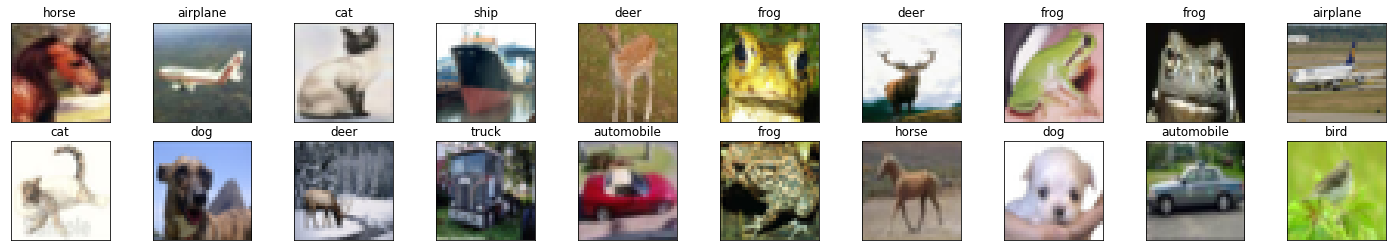

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

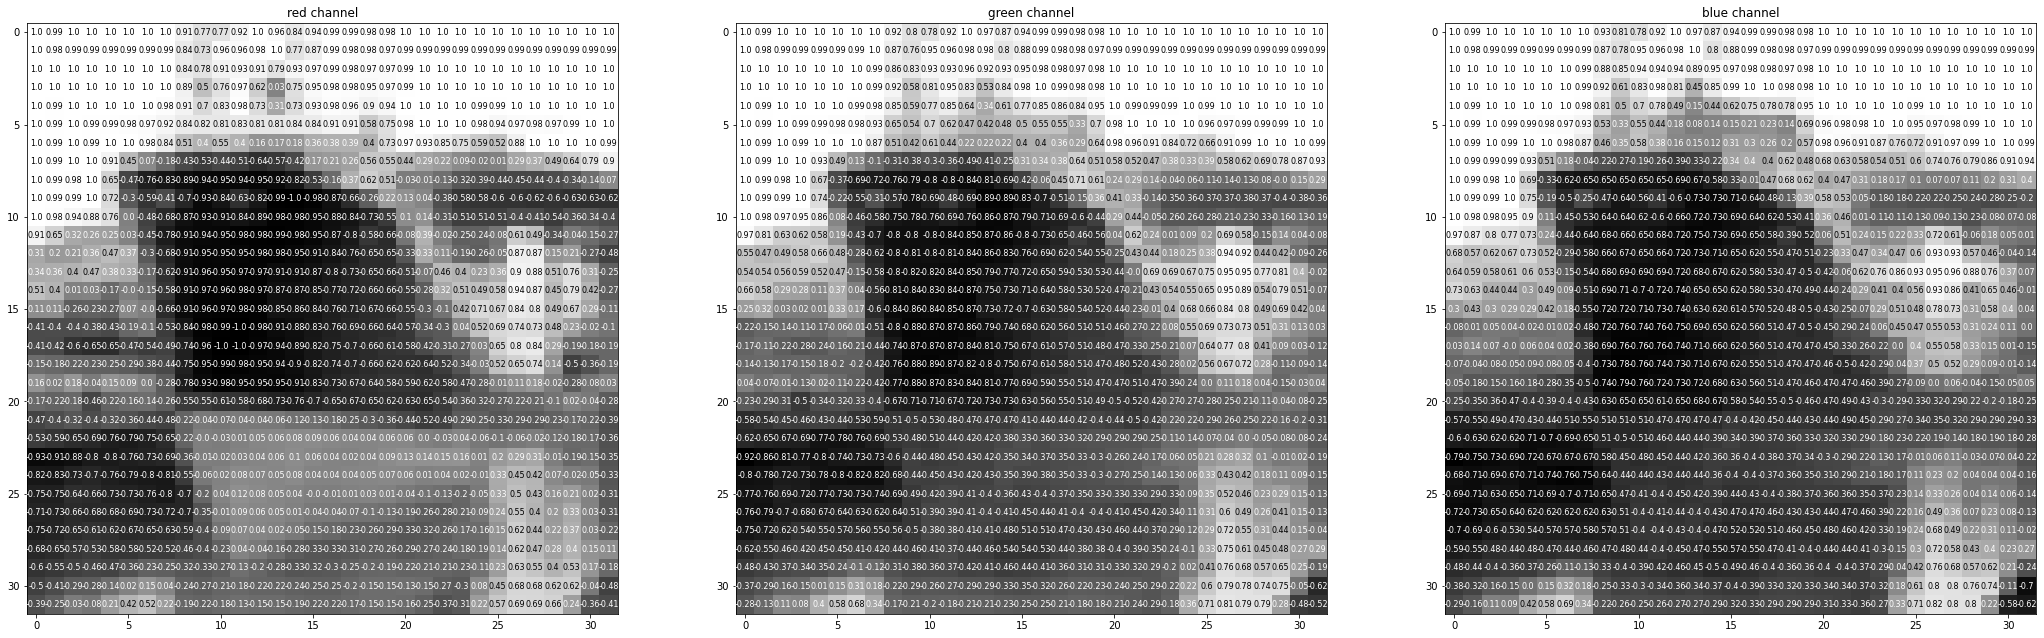

In [5]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Defining the Network Architecture

In [6]:
from torch import nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(8 * 8 * 32, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.output = nn.Linear(256, 10)
        
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x
    
model = Network()
print(model)

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [7]:
# test for cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('training on : ', device)
model.cuda()
# model = model.to(device)

training on :  cuda:0


Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

## Training the Network

In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

In [9]:
n_epochs = 30
valid_loss_min = np.Inf

for epoch in range(n_epochs):
    train_loss, valid_loss = 0.0, 0.0
    
    model.train()
    for images, labels in train_loader:
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        op = model(images)
        loss = criterion(op, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    model.eval()
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        op = model(images)
        loss = criterion(op, labels)
        
        valid_loss += loss.item()
        
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f}--> {:.6f}).\tSaving model ...\n'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 4452.245339 	Validation Loss: 1013.608769
Validation loss decreased (inf--> 1013.608769).	Saving model ...

Epoch: 2 	Training Loss: 3672.315515 	Validation Loss: 849.630138
Validation loss decreased (1013.608769--> 849.630138).	Saving model ...

Epoch: 3 	Training Loss: 3152.580279 	Validation Loss: 741.874508
Validation loss decreased (849.630138--> 741.874508).	Saving model ...

Epoch: 4 	Training Loss: 2872.961730 	Validation Loss: 700.801259
Validation loss decreased (741.874508--> 700.801259).	Saving model ...

Epoch: 5 	Training Loss: 2704.268436 	Validation Loss: 684.333638
Validation loss decreased (700.801259--> 684.333638).	Saving model ...

Epoch: 6 	Training Loss: 2564.488304 	Validation Loss: 628.986623
Validation loss decreased (684.333638--> 628.986623).	Saving model ...

Epoch: 7 	Training Loss: 2450.725442 	Validation Loss: 606.659651
Validation loss decreased (628.986623--> 606.659651).	Saving model ...

Epoch: 8 	Training Loss: 2340.148475 	